In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
#Importing dataset and sampling 10000 randomly for smooth processing
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df = df.sample(10000, ignore_index=True)
df.shape

(10000, 2)

In [3]:
df.head()

,review,sentiment
0,White man + progress + industrialization = BAD...,positive
1,"Tracy and Matt, Michelle and Sebastian: these ...",positive
2,How does this movie suck? As a fan of Michael ...,negative
3,"A true story about a true revolution, 25 of Ap...",positive
4,"I admit it's very silly, but I've practically ...",positive


sentiment
positive    5018
negative    4982
Name: count, dtype: int64


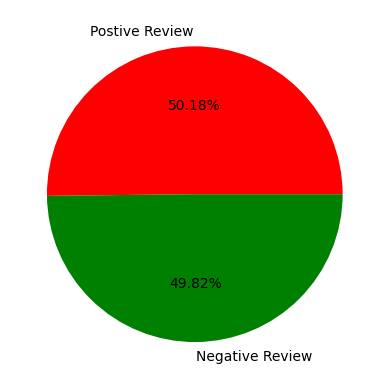

In [4]:
#Checking the class balance of the dataset
print(df['sentiment'].value_counts())
plt.pie(labels=['Postive Review', 'Negative Review'], 
        x = df['sentiment'].value_counts().values,
        autopct='%.2f%%',
        colors = ['red', 'green'])
plt.show()

In [5]:
#cleaning the text for punctuations or other junk

def clear_text(text):
    text = text.lower().replace('<br /><br />', '').replace('\x85', '').replace('\x96', '')
    text = text.replace('n\'t', ' not').replace('\'ve', ' have')
    text = re.sub('[^a-z\s]', '', text)
    return text


df['review (cleared)'] = df['review'].apply(clear_text)

In [6]:
import nltk
import subprocess

# Downloading and unzipping wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# importing the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [7]:
#Tokenizing, pos-tagging, lemmatising and finally adding words together for stem meaning

pos_dict = {'A': wordnet.ADJ, 'N': wordnet.NOUN, 'R': wordnet.ADV, 'V': wordnet.VERB}
lm = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words.remove('not')


def text_preprocessing(text):
    updated_pos = []
    sentence = ''
    pos_text = pos_tag(word_tokenize(text))
    for word, tag in pos_text:
        if word not in set(stop_words):
            updated_pos.append(tuple([word, (pos_dict.get(tag[0].lower()))]))
    for word, tag in updated_pos:
        if not tag:
           sentence += ' ' +  word
        else:
            sentence += ' ' + lm.lemmatize(word)
    return sentence.strip()

df['review (lemma)'] = df['review (cleared)'].apply(text_preprocessing)

In [8]:
print('Original Review: \n' + df['review'][0])
print('Cleared Review: \n'+ df['review (cleared)'][0])
print('Lemmatized Review: \n'+ df['review (lemma)'][0])

Original Review: 
White man + progress + industrialization = BAD. First nations + nature + animals = GOOD. Simple formula. Actually, in past days the same kind of propaganda was used to defend the status quo; now it is used to attack it. However, that being said, I think the movie does succeed in overcoming hackneyed politicization because it plays to the themes of freedom and original nature in a way that appeals to everyone. You may not be onside with the movie's rubbishy revisionism of how the West was won, er lost. But anyone can feel a sense of longing for the days when horses could run free on the Western plains. (The movie also conveniently sidesteps the fact that there were no horses in America before the evil white man brought them there). Anyway, I liked it. The quality of the animation - especially the opening shot - is incredible.
Cleared Review: 
white man  progress  industrialization  bad first nations  nature  animals  good simple formula actually in past days the same k

In [9]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
#Doing a sentiment analysis from the text data to check validity of labels
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

#Cheaking a single sentence poality score
print(sia.polarity_scores(df['review (lemma)'][0]))

#Creating a function to measure sentiment score of the datatset

def sentiment_score(text):
    score = sia.polarity_scores(text)
    if score.get('compound') > 0.05:
        return 'positive'
    else:
        return 'negative'
    
df['vader sentiment'] = df['review (lemma)'].apply(sentiment_score)

{'neg': 0.154, 'neu': 0.593, 'pos': 0.253, 'compound': 0.8885}


In [11]:
sentiment_df = df[['sentiment', 'vader sentiment']]

#Plotting the sentiment in pie chart

fig = make_subplots(rows = 1, 
                    cols = 2, 
                    subplot_titles = ['True Label sentiment', 'Vader Sentiment'],
                   specs = [[{'type': 'domain'}, {'type': 'domain'}]])

fig.add_trace(go.Pie(labels = df['sentiment'].value_counts().index, 
                     values = df['sentiment'].value_counts().values), 
              row = 1, 
              col = 1)
fig.add_trace(go.Pie(labels = df['vader sentiment'].value_counts().index,
                    values = df['vader sentiment'].value_counts().values),
             row = 1,
             col = 2)

fig.update_layout(legend = dict(title= 'Review'), width=800, height=600)

fig.show()

In [12]:
#Creating indepedent and depedent variable
X = df['review (cleared)']
y = df['sentiment'].values

#Label encoding the depedent variable
le = LabelEncoder()
y = le.fit_transform(y)

#Creating train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [13]:
#Using countvectoriser for creating bag of words
cv = CountVectorizer()
X_train_c = cv.fit_transform(X_train).toarray()
X_test_c = cv.transform(X_test).toarray()

#Using naive bayes algorithm to predict the sentiment
gnbc = GaussianNB()
gnbc.fit(X_train_c, y_train)

#Evaluting the model based on the true sentiment
y_pred = gnbc.predict(X_test_c)
ac = accuracy_score(y_pred, y_test)
cf = confusion_matrix(y_pred, y_test)
report_1 = classification_report(y_pred, y_test)
print(f'Accuracy Score: {round(ac*100, 2)}%')
print(f'Confusion Matrix: \n{cf}')
print(f'Classification Report: \n{report_1}')

Accuracy Score: 63.45%
Confusion Matrix: 
[[682 430]
 [301 587]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1112
           1       0.58      0.66      0.62       888

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.64      0.63      0.64      2000



In [14]:
#Using random forest algorithm to predict the sentiment
rfcc = RandomForestClassifier()
rfcc.fit(X_train_c, y_train)

#Evaluting the model based on the true sentiment
y_pred = rfcc.predict(X_test_c)
ac = accuracy_score(y_pred, y_test)
cf = confusion_matrix(y_pred, y_test)
report_2 = classification_report(y_pred, y_test)
print(f'Accuracy Score: {round(ac*100, 2)}%')
print(f'Confusion Matrix: \n{cf}')
print(f'Classification Report: \n{report_2}')

Accuracy Score: 82.95%
Confusion Matrix: 
[[831 189]
 [152 828]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1020
           1       0.81      0.84      0.83       980

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [15]:
#Using Tfidf for creating bag of words
cv = TfidfVectorizer()
X_train_t = cv.fit_transform(X_train).toarray()
X_test_t = cv.transform(X_test).toarray()

#Using naive bayes algorithm to predict the sentiment
gnbt = GaussianNB()
gnbt.fit(X_train_t, y_train)

#Evaluting the model based on the true sentiment
y_pred = gnbt.predict(X_test_t)
ac = accuracy_score(y_pred, y_test)
cf = confusion_matrix(y_pred, y_test)
report_1 = classification_report(y_pred, y_test)
print(f'Accuracy Score: {round(ac*100, 2)}%')
print(f'Confusion Matrix: \n{cf}')
print(f'Classification Report: \n{report_1}')

Accuracy Score: 62.6%
Confusion Matrix: 
[[612 377]
 [371 640]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       989
           1       0.63      0.63      0.63      1011

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



In [16]:
#Using random forest algorithm to predict the sentiment
rfct = RandomForestClassifier()
rfct.fit(X_train_t, y_train)

#Evaluting the model based on the true sentiment
y_pred = rfct.predict(X_test_t)
ac = accuracy_score(y_pred, y_test)
cf = confusion_matrix(y_pred, y_test)
report_2 = classification_report(y_pred, y_test)
print(f'Accuracy Score: {round(ac*100, 2)}%')
print(f'Confusion Matrix: \n{cf}')
print(f'Classification Report: \n{report_2}')

Accuracy Score: 81.85%
Confusion Matrix: 
[[821 201]
 [162 816]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1022
           1       0.80      0.83      0.82       978

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [17]:
# Creating a general function for output generation
def output_sentiment(text):
    transformed_input = cv.transform([text]).toarray()
    if rfct.predict(transformed_input)[0] == 0:
        return 'Negative'
    else:
        return 'Positive' 

In [18]:
neg_text = '''My biggest disappointment with this phone is the UI. MIUI is a terrible OS if you're into customization and other things. 
Firstly, don't expect a lot of features that were offered. Xiaomi locks many of the MIUI features for China only, 
but also locks them out of lower-end devices like this. Secondly, they have disabled full-screen gestures if you're using a custom launcher. 
The default MIUI launcher is terrible as well and just doesn't look good. For an individual who is accustomed to the stock Android experience, 
the MIUI 14 has been a dismal experience after almost 20 days of using the phone.'''

print(output_sentiment(neg_text))

Negative


In [19]:
pos_text = '''I recently purchased a new phone, and I must say I'm quite impressed with its features. 
The camera is fantastic, delivering crisp and vibrant photos, making it a perfect companion for capturing memories. 
The large screen provides an immersive viewing experience, and the 22-watt supercharging ensures that my phone is juiced up in no time, 
keeping me connected throughout the day.'''

print(output_sentiment(pos_text))

Positive
